In [ ]:
import pandas as pd
import re
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("broad_sector.csv")

In [ ]:
def to_period_str_quarter(s):
    if not s or pd.isna(s):
        return None
    s = str(s).strip()
    # Match pattern like "Q1 2017" (quarter + space + year)
    m = re.match(r'^[Qq]([1-4])\s+(\d{4})$', s)
    if m:
        q, y = m.groups()
        return f"{y}Q{q}"
    return None  # return None if not matched

# **CAREER TRANSITION SANKEY**

# ***“If my first job isn’t in my dream field, am I stuck there forever?”***

In [ ]:
df['start_quarter_str'] = df['start_date'].apply(to_period_str_quarter)
df['end_quarter_str'] = df['end_date'].apply(to_period_str_quarter)

df['start_quarter'] = pd.PeriodIndex([p if p is not None else pd.NaT for p in df['start_quarter_str']], freq='Q')
df['end_quarter'] = pd.PeriodIndex([p if p is not None else pd.NaT for p in df['end_quarter_str']], freq='Q')

df['cohort'] = df.groupby('person_id')['start_quarter'].transform('min')
df['cohort_str'] = df['cohort'].astype(str)

first = df.sort_values('start_quarter').groupby('person_id').first().reset_index()
last = df.sort_values('start_quarter').groupby('person_id').last().reset_index()
sector_flow = pd.merge(
    first[['person_id', 'broad_sector', 'cohort']],
    last[['person_id', 'broad_sector']],
    on='person_id',
    suffixes=('_first', '_last')
)

palette = [
    "#6BAED6", "#FD8D3C", "#74C476", "#A1D99B",
    "#9E9AC8", "#FDD0A2", "#E377C2", "#B3DE69",
    "#D62728", "#17BECF"
]
node_colors = [palette[i % len(palette)] for i, _ in enumerate(all_labels)]
link_colors = [node_colors[label_to_index[s]] for s in transition_counts['broad_sector_first']]

def hex_to_rgba(hex_color, alpha=0.4):
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return f"rgba({r},{g},{b},{alpha})"

link_colors = [hex_to_rgba(c, alpha=0.7) for c in link_colors]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=all_labels,
        line=dict(color="black", width=0.5),
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])
fig.update_layout(title_text="Career Transition Flow: First → Final Broad Sector", font_size=12)
fig.show()

***What does the graph tell you***

The Sankey diagram tracks transitions from first to final career sectors. It reveals that many graduates move across fields — for example, from Sales/Business to Tech or Education. Career paths are fluid, not fixed.


***What This Means for Graduates***

Your first job often acts as a launchpad, not a lifelong label. So, no, you aren't stuck with your first job forever. The data shows that transferable skills and continuous learning enable movement between industries. Instead of worrying about the “perfect” start, graduates, work on gaining skills and experiences that open future opportunities!

## ***“If I start in a business or sales role, will I be able to move to another field later?”***

In [ ]:
flow_df = pd.merge(
    first[['person_id', 'broad_sector']],
    last[['person_id', 'broad_sector']],
    on='person_id',
    suffixes=('_first', '_last')
)

# Filter for a specific starting sector
sector = "Sales / Business / Support"
subset = flow_df[flow_df['broad_sector_first'] == sector]

total = len(subset)
switched = (subset['broad_sector_first'] != subset['broad_sector_last']).sum()
stayed = total - switched
percent_switched = (switched / total) * 100
percent_stayed = 100 - percent_switched

print(f"Out of {total} people who started in '{sector}':")
print(f"✅ {percent_stayed:.1f}% stayed in the same sector.")
print(f"🔁 {percent_switched:.1f}% switched to a different sector.")


Out of 60275 people who started in 'Sales / Business / Support':
✅ 65.4% stayed in the same sector.
🔁 34.6% switched to a different sector.


***What does the data say?***

From the dataset of 60,275 individuals who began in Sales / Business / Support, about 65.4% stayed in the same sector, while 34.6% transitioned into different fields such as Tech, Education, or Public Sector roles.

***What do the graduates need to know?***

This indicates that while a majority continue in similar roles, over one-third successfully switch sectors — showing that change is possible with the right skills and timing. Career mobility is definitely possible, even for those starting in non-technical domains.

## **INSIGHTS: Career Transition Sankey**
* Sales / Business / Support has the thickest outflow suggesting high churn, possibly low retention or entry-level saturation. 34.6% of people who start in Sales don’t end their careers there.
* Others / Unclassified shows high absorption, indicating poor labeling or non-traditional career paths and a need to clean/refine this category if possible.
* Engineering / Technicians and Education also absorb from multiple sources which can be a sign of stable or fallback sectors. May reflect stability, growth, or late-career retraining.
* Career Uncertainty & Fluidity: The diversity of paths suggests that careers are non-linear. Life circumstances, opportunity, and personal growth drive transitions.
* **Sales as a Starting Point:** Sales is an on-ramp, not a destination, for many. It’s common to start in sales and then pivot elsewhere.
* Visual loops (start and end at same block) show stickiness: Healthcare, Education, and Tech show high self-loops. These sectors tend to have structured, long-term career tracks.

# **SECTOR RETENTION**

## ***"Does the field I choose for my first job affect how stable my career will be?"***

In [ ]:
sector_retention = (
    flow_df.groupby('broad_sector_first')
    .apply(lambda x: (x['broad_sector_first'] == x['broad_sector_last']).mean() * 100)
    .sort_values(ascending=False)
)
print(sector_retention.round(1))

broad_sector_first
Sales / Business / Support    65.4
Education                     49.3
Healthcare                    48.1
Tech / IT & Software          42.1
Engineering / Technicians     41.1
Others / Unclassified         40.5
Public Sector / Admin         25.2
Creative / Media              24.8
dtype: float64


/tmp/ipython-input-461511426.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



***What's the data telling us?***

Retention rates across sectors show major differences:
Highest in *Sales / Business / Support (65.4%)*, meaning most remain in business-oriented roles.

*Education (49.3%) and Healthcare (48.1%)* also show moderate stability.

*Tech (42.1%) and Engineering (41.1%)* see more frequent switching, often toward management or interdisciplinary roles.

Lowest retention in *Creative (24.8%) and Public Sector (25.2%)*, reflecting highly mobile or shifting career paths.

***Takeaway for the graduates***

Simply put- career mobility is common everywhere,but adaptability and your growth in skills decide if you stay or shift.

# ***“Are graduates today more likely to stay in the same field they started in compared to older generations?”***


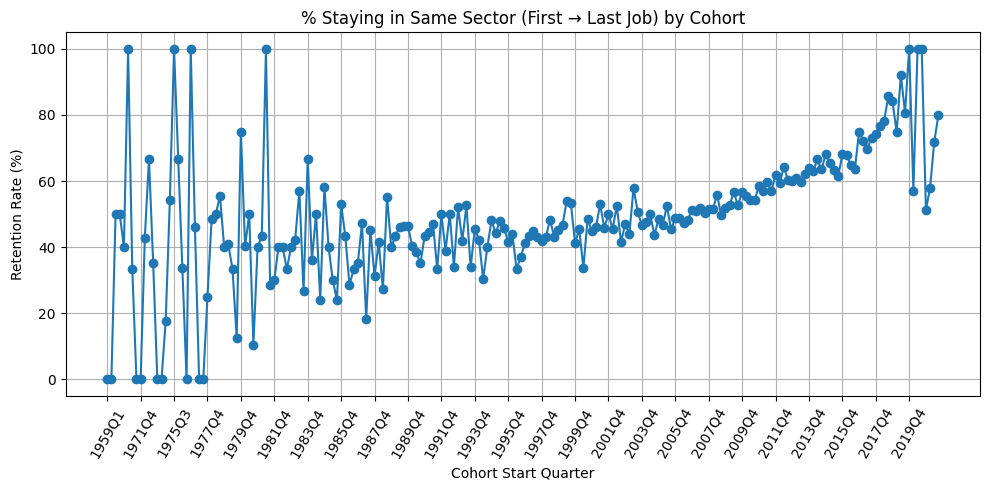

In [ ]:
#Retention Rate by Cohort
sector_flow['same_sector'] = sector_flow['broad_sector_first'] == sector_flow['broad_sector_last']
retention = sector_flow.groupby('cohort')['same_sector'].mean().reset_index()
retention['cohort'] = retention['cohort'].astype(str)

plt.figure(figsize=(10, 5))
plt.plot(retention['cohort'], retention['same_sector'] * 100, marker='o')
plt.xticks(rotation=45)
plt.title('% Staying in Same Sector (First → Last Job) by Cohort')
plt.xlabel('Cohort Start Quarter')
plt.ylabel('Retention Rate (%)')
plt.grid(True)

plt.xticks(retention['cohort'][::8], rotation=60)
plt.tight_layout()
plt.show()

***What's the graph showing?***

The line graph shows that early cohorts (before the 1990s) experienced greater variability and lower retention, often under 50%. However, from the 2000s onward, there’s a steady rise in sector retention, reaching over 70–80% for more recent cohorts. This suggests that graduates entering the job market now tend to remain longer in their original fields.

***What This Means for Graduates:***

Modern career paths appear more stable and specialized. Your first job now holds more influence than in the past—it’s increasingly likely to shape your long-term professional direction. Graduates should therefore choose their first job strategically, aligning it with their interests and future goals rather than treating it as a short-term experiment.

# ***“Which fields give me the most flexibility to change careers later on?”***

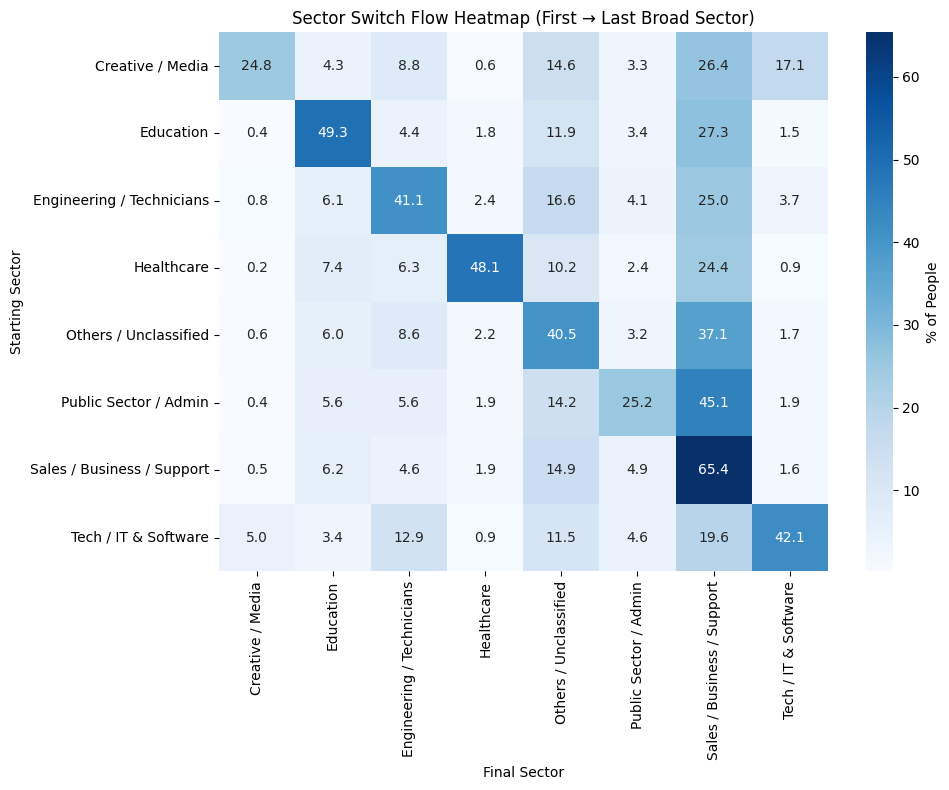

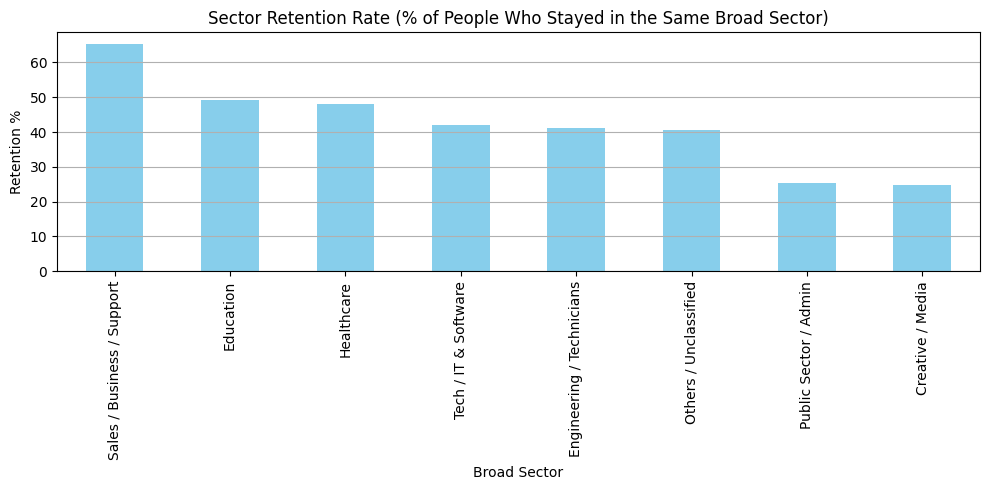

Top 5 Most Retentive Sectors:
Sales / Business / Support    65.40
Education                     49.34
Healthcare                    48.09
Tech / IT & Software          42.11
Engineering / Technicians     41.13
dtype: float64

Top 5 Most Volatile Sectors (lowest retention):
Creative / Media             24.81
Public Sector / Admin        25.24
Others / Unclassified        40.54
Engineering / Technicians    41.13
Tech / IT & Software         42.11
dtype: float64


In [ ]:
# Build transition matrix
transition_matrix = pd.crosstab(first['broad_sector'], last['broad_sector'])
transition_percentage = transition_matrix.div(transition_matrix.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(transition_percentage, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': '% of People'})
plt.title('Sector Switch Flow Heatmap (First → Last Broad Sector)')
plt.xlabel('Final Sector')
plt.ylabel('Starting Sector')
plt.tight_layout()
plt.show()

# Retention rate per sector
retention = pd.Series(dtype=float)
for sector in transition_matrix.index:
    same = transition_matrix.loc[sector, sector] if sector in transition_matrix.columns else 0
    total = transition_matrix.loc[sector].sum()
    retention[sector] = (same / total) * 100 if total > 0 else 0

retention.sort_values(ascending=False).plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title('Sector Retention Rate (% of People Who Stayed in the Same Broad Sector)')
plt.ylabel('Retention %')
plt.xlabel('Broad Sector')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("Top 5 Most Retentive Sectors:")
print(retention.sort_values(ascending=False).head(5).round(2))

print("\nTop 5 Most Volatile Sectors (lowest retention):")
print(retention.sort_values().head(5).round(2))


***What are the graphs saying?***
The heatmap reveals the flow of people moving between sectors — while some fields like Sales / Business / Support show strong internal movement (most people staying within the same field), others like Creative / Media and Public Sector display wide cross-sector transitions.
The bar chart quantifies these trends:
Sales / Business / Support (65%), Education (49%), and Healthcare (48%) are the most stable sectors.
Creative / Media (25%) and Public Sector (25%) are the most volatile, meaning people frequently shift to other industries.
Together, they paint a clear picture: sector choice significantly affects career stability and flexibility.

***Graduates?***

Your first job’s sector can heavily influence how your career unfolds — not necessarily in the specific company or title, but in the type of work you stay close to.
Starting in a stable field like Business or Education might lead to a long-term career in that domain.
Entering dynamic spaces like Creative or Public Sector could mean frequent transitions, experimentation, and broader skill exposure.
In essence, your first job doesn’t trap you, but the sector it’s in sets your level of flexibility. Graduates should think beyond the role title and consider: “What kind of field am I stepping into — one that grows deep roots, or one that lets me branch out?”

## **INSIGHTS: Sector Retention**
* Volatility in pre-1990s cohorts: Retention rates are erratic and lower (less than 50%) for people who started careers before the 1990s. This could reflect incomplete career data for older cohorts (still ongoing or less complete resumes), more experimental career paths historically or Dataset sparsity and survivorship bias in early records.
* Retention has increased steadily since 2000. Retention rose from ~40–50% to 70–85% for cohorts starting after 2010. Post-2015 cohorts show peaks even near 90–100%, suggesting greater sectoral stability early in careers. Possibly due to better specialization from education, job market saturation encouraging long-term anchoring or a shift to tech-enabled credentialed sectors where switching is harder.
* Nearly 50% of people working in Education and Healthcare tend to retain their jobs.


# **SECTOR RETURNERS**
# ***“If I leave my first field, will I ever come back to it later in my career?”***

🔁 Looping Pattern Detected:
 broad_sector
False    101515
True      13419
Name: count, dtype: int64


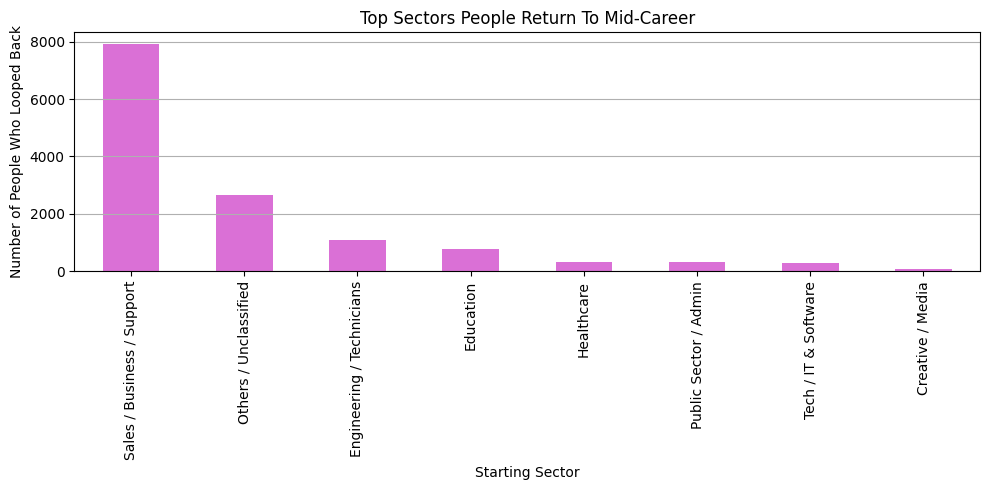

In [ ]:
# Sort the data for each person chronologically
df_sorted = df.sort_values(['person_id', 'start_quarter'])

# Detect loopers
def went_back(sector_series):
    return (
        len(sector_series) >= 3 and
        sector_series.iloc[0] != sector_series.iloc[-1] and
        sector_series.iloc[0] == sector_series.iloc[-2]
    )

loop_flags = df_sorted.groupby('person_id')['broad_sector'].apply(went_back)

loop_counts = loop_flags.value_counts()
print("🔁 Looping Pattern Detected:\n", loop_counts)

loop_df = df_sorted.copy()
loop_df['looped_back'] = loop_df['person_id'].map(loop_flags)

first_sector = df_sorted.groupby('person_id').first().reset_index()
first_sector['looped_back'] = first_sector['person_id'].map(loop_flags)

loop_sector_counts = first_sector[first_sector['looped_back'] == True]['broad_sector'].value_counts()

plt.figure(figsize=(10,5))
loop_sector_counts.sort_values(ascending=False).plot(kind='bar', color='orchid')
plt.title('Top Sectors People Return To Mid-Career')
plt.ylabel('Number of People Who Looped Back')
plt.xlabel('Starting Sector')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


***What the Analysis Shows***

This chart identifies people who looped back to their original sector after exploring other fields. About 13,400 individuals showed this pattern. The majority came from Sales / Business / Support, far outpacing all other sectors. Smaller but notable looping patterns appear in Engineering / Technicians and Education, while Creative, Tech, and Public Sector roles show very few returns.
This suggests that some sectors — especially Business-related fields — act as reliable fallback options that professionals often return to after experimenting elsewhere.

***What This Means for Graduates***

Even if you leave your first field, the data shows you’re not necessarily closing the door on it forever. Many professionals circle back to their roots, particularly in broad skill-based areas like business, management, or technical services.
For graduates, this means your first job builds a foundation you can always return to — it shapes your long-term identity and marketability. In other words, your first job matters both as a launchpad and a safety net.

## **INSIGHTS: Sector Returners**
* 13,419 people (≈12%) return to their original sector mid-career. Indicates a non-linear career path for a significant portion of workers. These are people who experiment with other fields but find their way back — potentially due to expertise, comfort, or opportunity.
* Sales / Business / Support dominates loopbacks. Nearly 8,000 loopbacks — far ahead of any other sector. Could suggest: Sales as a fallback career,Transferable skills across sectors or Entry-level accessibility and wide availability of roles.
* Low return-to-sector behavior in Creative / Media and Tech / IT & Software. May suggest that when people leave these sectors, they rarely return. Possibly due to fast-paced changes or upskilling barriers in tech or career burnout in creative industries.
* Loopbacks may reflect “Trial and Error” Career Exploration. Even when people pivot, there's often a gravitational pull back to familiarity or competence

# **LATE CAREERS**
***“Where do people usually end up by the end of their careers — and does the first job influence that destination?”***

In [ ]:
df_sorted = df.sort_values(['person_id', 'start_quarter'])
df_sorted['job_number'] = df_sorted.groupby('person_id').cumcount() + 1
df_sorted['total_jobs'] = df_sorted.groupby('person_id')['broad_sector'].transform('count')

final_jobs = df_sorted.groupby('person_id').last().reset_index()
late_sector_counts = final_jobs['broad_sector'].value_counts()

print("📊 Late-career (final job) sector distribution:")
print(late_sector_counts)

📊 Late-career (final job) sector distribution:
broad_sector
Sales / Business / Support    56727
Others / Unclassified         22666
Education                     10792
Engineering / Technicians     10682
Public Sector / Admin          5719
Healthcare                     3869
Tech / IT & Software           3478
Creative / Media               1001
Name: count, dtype: int64


***Analysis***

In late-career stages, the largest proportion of professionals are concentrated in Sales / Business / Support (56,727 people), followed by Unclassified / Others (22,666), Education (10,792), and Engineering / Technicians (10,682). Smaller proportions remain in Public Sector (5,719), Healthcare (3,869), Tech (3,478), and Creative / Media (1,001).
Combined with earlier findings (retention, switching, and looping data), this shows that Sales / Business / Support consistently dominates across first, mid, and final career stages. It’s not only where many start — it’s where many ultimately return or stay.

***Graduates***

The data suggests that certain sectors — especially business-related roles — serve as career anchors, drawing professionals back even after exploration. This trend reinforces that your first job sector can shape your long-term trajectory, directly or indirectly.
Graduates should view their first job as both a training ground and a potential endpoint. Even if they branch out into other fields, the foundational skills and networks built in that first sector often influence where they eventually find long-term stability.

## **INSIGHTS: Late Careers**
* Others / Unclassified has about 23000 final jobs, which may reflect either non-traditional, gig-based, or ambiguous job roles near retirement or a lack of precise job classification in the data.
* The Public Sector / Admin captures nearly 6,000 final roles, suggesting it provides stability and benefits that may appeal to those nearing retirement or seeking secure end-of-career positions.
* Healthcare also retains a decent share of final roles, aligning with known trends of long tenures due to professional licensing and mission-driven careers.
* The fact that only 3,478 people finish in Tech / IT & Software may imply that while tech is a common mid-career switch, fewer end their careers here—potentially due to burnout, rapid change, or transitions into managerial tracks that are reclassified under other sectors.

***Supporting Literature and External Findings***
* *Job Switching Interest Is High:* <br>
In mid-2025, 64% of Belgians considered changing jobs in the coming year. A further 22.3% were actively job-hunting—the highest figure in 10 years. This supports our findings that many workers start in non-tech fields but later transition into tech or other sectors, reflecting instability in early career paths. [1,2]
* *Late-Career Inertia Is High:* <br>
While many want to switch, only 19% changed roles internally in 5 years. Our late-career distribution charts align with this—sectors like Healthcare and Admin see fewer late-stage exits, showing career inertia. [3]
* *Career Breaks Encourage Returners:* <br>
Belgian law allows up to 1 year of career break with job return guarantees. This may explain the small but consistent return-to-sector transitions in our data—especially in public sector and education roles. [4]
* *Sector Switching Is Common:* <br>
26% of Belgian employees surveyed wanted to change to a completely different sector, and 44% were considering changing roles or industries. This resonates with our sector-switching matrix, particularly cases like Education → Public Sector or Support → Tech. [1,5]
* *Radical Career Changes Are Rare but Real:* <br>
Although radical career switches are possible (e.g. social worker → tree surgeon), experts agree they’re rare without retraining or support systems. The data’s rare returner loops and long-tail transitions confirm this. [6] *italicized text*

1.   https://www.thebulletin.be/two-thirds-belgians-want-change-job#:~:text=Two,and%20job%20search%20site%20Stepstone
2.   https://www.brusselstimes.com/1610603/number-of-employees-actively-looking-for-new-job-at-highest-level-in-ten-years
3.   https://career.rightmanagement.be/insights/post/internal-mobility-as-the-cure-for-career-inertia#:~:text=A%20Belgian%20Reality%3A%20Loyalty%20Without,Movement
4.   https://www.hireborderless.com/post/career-breaks-and-time-credit-in-belgium#:~:text=Belgium%E2%80%99s%20labor%20law%20ensures%20that,for%20up%20to%20one%20year
5.   https://www.brusselstimes.com/1007994/one-in-four-belgians-are-considering-a-career-change
6.   https://www.thebulletin.be/time-breathe-new-life-your-career-youre-not-alone#:~:text=That%20sounds%20about%20right%2C%20says,%E2%80%9D